In [370]:
%matplotlib inline

import re
import json
import time
import random
import os.path
import requests
import warnings
import itertools
import urllib.parse
import urllib.request

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn import preprocessing

plt.style.use(["seaborn-whitegrid"])
plt.rcParams["figure.figsize"] = (10, 5)

#print(plt.style.available)

In [371]:
#Read in the symbol title dataframe
symbol_title = pd.read_csv("symbol_title.csv", index_col=2, sep=",")
symbol_title = symbol_title[["symbol","sector","industry"]]
symbol_title.dropna(inplace=True)
symbol_title.head()

,symbol,sector,industry
name,,,
AAC Holdings,AAC,Conglomerates,Conglomerates
Almaden Minerals Ltd.,AAU,Basic Materials,Industrial Metals & Minerals
American Biltrite Inc.,ABL,Consumer Goods,Rubber & Plastics
Acme United Corp.,ACU,Consumer Goods,Office Supplies
AeroCentury Corp.,ACY,Services,Rental & Leasing Services


In [372]:
security = pd.read_csv("security.csv", encoding="utf8")

In [373]:
#Allows an application to request user authorization. 
def oauth_authorize():    
    url = "https://api.stocktwits.com/api/2/oauth/authorize"                
    params = urllib.parse.urlencode({"client_id": security["client_id"][0], 
                                     "response_type": "token",
                                     "redirect_uri": "https://sites.google.com/site/noelnamai/",
                                     "scope": "read,watch_lists,publish_messages,publish_watch_lists,follow_users,follow_stocks"
                                    })    
    oauth = urllib.request.urlopen(url, params.encode("UTF-8"))    
    return oauth

In [374]:
oauth = oauth_authorize()

In [375]:
#Returns the most recent 30 messages for the specified symbol. Includes symbol object in response.
def stream_symbol(symbol):
    url = "https://api.stocktwits.com/api/2/streams/symbol/" + str(symbol) + ".json"
    try:
        content = requests.get(url).json()
    except Exception as error:
        raise Exception("Method: stream_symbol. Error: " + str(error))
    return content

In [376]:
#Returns the most recent 30 messages with trending symbols in the last 5 minutes.
def stream_trending():             
    url = "https://api.stocktwits.com/api/2/streams/trending.json"
    payload = {"access_token": security["access_token"][0]}
    try:    
        content = requests.get(url, params=payload).json()
    except Exception as error:
        raise Exception("Method: stream_trending. Error: " + str(error))
    return content

In [377]:
#Returns the most recent 30 symbols in the last 5 minutes.
def get_symbols():
    symbols = []
    data = stream_trending()
    code = data["response"]["status"] 
    for tweet in data["messages"]:
        for symbol in tweet["symbols"]:
            symbols.append(symbol["symbol"])
    return code, symbols

In [378]:
#Creates a dataframe from JSON data returned by the API.
def create_dataframe(data): 
    response = [] 
    code = data["response"]["status"]                                  
    if code == 200: 
        for tweet in data["messages"]:
            for symbol in tweet["symbols"]:
                utc = datetime.strptime(tweet["created_at"], "%Y-%m-%dT%H:%M:%SZ")
                row = {"symbol": symbol["symbol"],
                       "title": symbol["title"],
                       "tweet_id": tweet["id"],
                       "text": tweet["body"],
                       "date": str(utc.date()),
                       "time": str(utc.time()),
                       "weekday": utc.weekday(),
                       "name": tweet["user"]["name"],
                       "user_id": str(tweet["user"]["id"]),
                       "user_name": str(tweet["user"]["username"])}
                response.append(row) 
    else: 
        raise Exception("Method: create_dataframe " + "Error: " + str(data["errors"][0]["message"]))
    df = pd.DataFrame(response)
    return code, df

In [379]:
#Clean the data frame and fill in the missing data
def clean_dataframe(df):
    df = df.drop_duplicates()    
    df = df.dropna() 
    df["weekday"] = df["weekday"].astype("int")
    df["tweet_id"] = df["tweet_id"].astype("int")
    df.sort_values(["tweet_id","time"], ascending=True, inplace=True)
    df["index"] = range(len(df))
    df = df.set_index("index")
    return df

In [380]:
#Fill in the data "sector" and "industry" to the main dataframe.
def fill_dataframe(x):   
    symbol = list(set(x["symbol"].values))[0]
    sector = symbol_title["sector"][symbol_title["symbol"] == symbol].values
    industry = symbol_title["industry"][symbol_title["symbol"] == symbol].values
    x["sector"] = sector[0] if len(sector) == 1 else np.nan
    x["industry"] = industry[0] if len(industry) == 1 else np.nan   
    return x

In [381]:
def get_network_measures(network):
    degree_list = list(network.degree().values())
    N = len(network)
    L = network.size()
    kmin = min(degree_list)
    kmax = max(degree_list)
    print("\nN :", N, 
          "\nL :", L, 
          "\nMinimum degree :", kmin, 
          "\nMaximum degree :", kmax, 
          "\nAverage degree :", np.mean(degree_list))

In [382]:
def log_binning_plot(values, title):
    kmin = min(values)
    kmax = max(values)
    
    #Get n logarithmically spaced bins between kmin and kmax
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)
    
    #histogram the data into these bins
    density, _ = np.histogram(values, bins=bin_edges, density=True)
    
    #"x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    fig = plt.figure(figsize=(7.5,7.5))
    plt.loglog(x, density, marker="o", linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=12)
    plt.ylabel(r"$P(k)$", fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()

In [383]:
#Read data frame. Creat a new one if non exists.
#df = pd.DataFrame(columns=["date","name","symbol","text","time","weekday","title","tweet_id","user_id","user_name"])
df = pd.read_csv("stocktwits_df.csv", encoding="utf8")  

#Get trending symbols and start building a dataframe from them.
code, symbols = get_symbols()
np.random.shuffle(symbols)
for symbol in symbols:
    data = stream_symbol(symbol)
    code, df2 = create_dataframe(data)
    df = df.append(df2) 
    df.to_csv("stocktwits_df.csv", index=False, encoding="utf-8") 
    time.sleep(20)

In [384]:
#df = pd.read_csv("stocktwits_df.csv", encoding="utf8")  
df = clean_dataframe(df) 
df = df.groupby("symbol").apply(fill_dataframe)
df["hour"] = [s.split(":")[0] for s in df["time"]]
df = df[df.date > "2016-09-31"].reset_index()
df["count"] = df.groupby(["symbol"])["user_name"].transform("count")
df[["date","name","symbol","time","hour","weekday","title","tweet_id","user_id","user_name"]].head()

,date,name,symbol,time,hour,weekday,title,tweet_id,user_id,user_name
0,2016-10-01,Andrew Kreimer,QTS,02:12:23,02,5,QTS Realty Trust,63822111,784233,algonell
1,2016-10-01,MarketBeat.com (Formerly ARN),SLF,03:47:49,03,5,Sun Life Financial Inc.,63824307,284225,AnalystRatingsNetwork
2,2016-10-01,Ben Silverberg,DECK,08:58:31,08,5,Deckers Outdoor Corp.,63827014,2843,silverjet2
3,2016-10-01,Ben Silverberg,ENDP,08:58:31,08,5,Endo Pharmaceuticals Holdings Inc.,63827014,2843,silverjet2
4,2016-10-01,Ben Silverberg,DFT,08:58:31,08,5,"DuPont Fabros Technology, Inc.",63827014,2843,silverjet2


In [385]:
df.shape[0]

24276

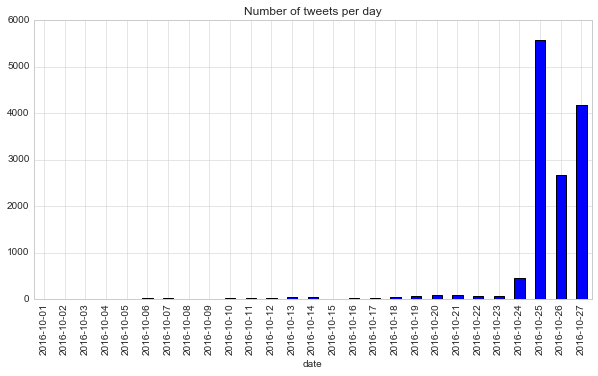

In [386]:
counts = df.groupby("date")["tweet_id"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", title="Number of tweets per day");

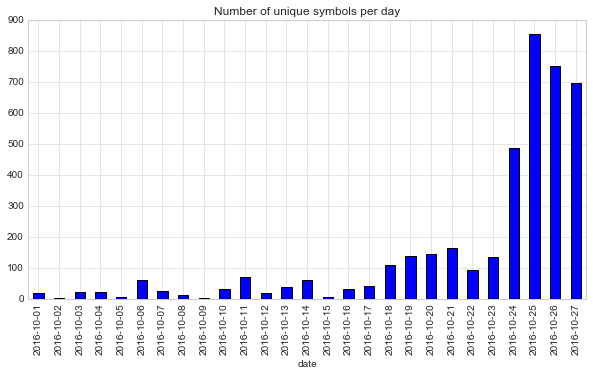

In [387]:
counts = df.groupby("date")["symbol"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", title="Number of unique symbols per day");

In [388]:
#Create a {"date": dataframe} dictionary
#Select only tweets sent on weekdays (Monday to Friday)
dataframes = {}
for date in df["date"].unique():
    dataframes[date] = clean_dataframe(df[(df["date"]==date) & (df["weekday"].values < 5)]).reset_index(drop=True)
    
print(dataframes.keys())

dict_keys(['2016-10-17', '2016-10-08', '2016-10-06', '2016-10-20', '2016-10-21', '2016-10-27', '2016-10-09', '2016-10-07', '2016-10-26', '2016-10-25', '2016-10-12', '2016-10-13', '2016-10-03', '2016-10-18', '2016-10-04', '2016-10-02', '2016-10-11', '2016-10-14', '2016-10-24', '2016-10-10', '2016-10-19', '2016-10-16', '2016-10-05', '2016-10-23', '2016-10-15', '2016-10-22', '2016-10-01'])


In [389]:
#df2 = dataframes["2016-10-25"]
df2 = df
df2[["name","date","symbol","time","hour","weekday","title","tweet_id","user_id","user_name"]].head()

,name,date,symbol,time,hour,weekday,title,tweet_id,user_id,user_name
0,Andrew Kreimer,2016-10-01,QTS,02:12:23,02,5,QTS Realty Trust,63822111,784233,algonell
1,MarketBeat.com (Formerly ARN),2016-10-01,SLF,03:47:49,03,5,Sun Life Financial Inc.,63824307,284225,AnalystRatingsNetwork
2,Ben Silverberg,2016-10-01,DECK,08:58:31,08,5,Deckers Outdoor Corp.,63827014,2843,silverjet2
3,Ben Silverberg,2016-10-01,ENDP,08:58:31,08,5,Endo Pharmaceuticals Holdings Inc.,63827014,2843,silverjet2
4,Ben Silverberg,2016-10-01,DFT,08:58:31,08,5,"DuPont Fabros Technology, Inc.",63827014,2843,silverjet2


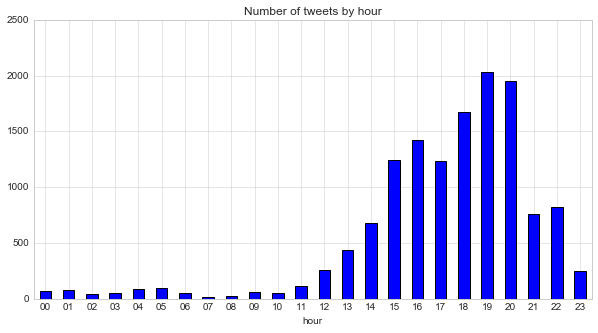

In [390]:
counts = df2.groupby("hour")["tweet_id"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", rot=0, title="Number of tweets by hour");

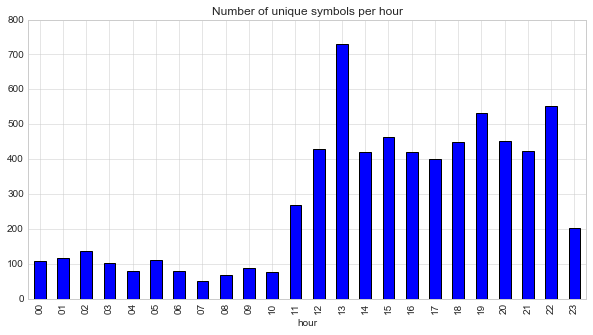

In [391]:
counts = df.groupby("hour")["symbol"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", title="Number of unique symbols per hour");

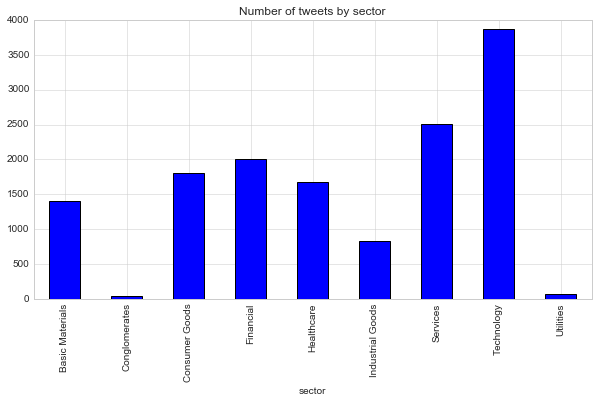

In [392]:
counts = df2.groupby("sector")["tweet_id"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", title="Number of tweets by sector");

In [393]:
network = nx.Graph()
network.add_nodes_from(df2["symbol"].values)

#create a dictionary of {tweet_id : [symbols]}
dict1 = {}
rdf = df2.groupby("tweet_id")
for tweet_id in list(set(df2.tweet_id.values)):
    dict1[tweet_id] = list(rdf.get_group(tweet_id).symbol.values) 

#Create and save the weighted graph for use in Gephi
for key, value in dict1.items():
    for tup in list(itertools.combinations(value, 2)):        
        source = tup[0]
        target = tup[1] 
        if source != target:
            if network.has_edge(source, target) == True:            
                network[source][target]["weight"] += 1
            else:
                network.add_edge(source, target, weight=1, key=str(key))

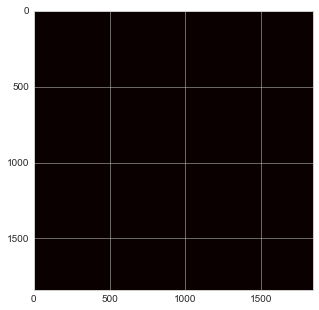

In [394]:
N = len(network.nodes())
matrix = [[0] * N] * N
for i in range(N):
    for j in range(N):
        if network.has_edge(i, j):
            matrix[i][j] = network[i][j]["weight"]
        
plt.imshow(matrix, cmap="hot", interpolation="nearest")
plt.show()

In [395]:
get_network_measures(network)


N : 1840 
L : 25823 
Minimum degree : 0 
Maximum degree : 332 
Average degree : 28.0684782609


In [396]:
remove = [(source, target) for source, target in network.edges_iter() if network[source][target]["weight"] < 1]
network.remove_edges_from(remove)

remove = [node for node in network.degree() if network.degree()[node] == 0]
network.remove_nodes_from(remove)

for source, target in network.edges_iter():
    network[source][target]["weight"] = 1

In [397]:
get_network_measures(network)


N : 1839 
L : 25823 
Minimum degree : 1 
Maximum degree : 332 
Average degree : 28.0837411637


In [398]:
#Add node attributes 
nodes  = []
titles = {}
sectors = {}
degrees = network.degree()

for node in network.nodes():
    titles[node] = df2["title"][df2.symbol==node].values[0]
    sectors[node] = df2["sector"][df2.symbol==node].values[0]
    industry = symbol_title["industry"][symbol_title.symbol==node].values
    nodes.append({"name": node, "title": titles[node], "industry": industry, "degree": degrees[node]})

nx.set_node_attributes(network, "Title", titles)
nx.set_node_attributes(network, "Sector", sectors)
nx.write_gexf(network, "symbol_graph.gexf")

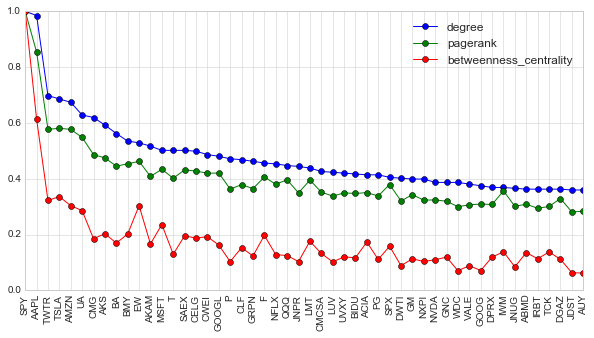

In [399]:
measures  = pd.DataFrame(index=network.nodes())
page_ranks = nx.pagerank(network)
btwns_clty = nx.betweenness_centrality(network)

measures["degree"] = [degrees[node] for node in measures.index]
measures["pagerank"] = [page_ranks[node] for node in measures.index]
measures["betweenness_centrality"] = [btwns_clty[node] for node in measures.index]

scaler = preprocessing.MinMaxScaler()
measures[["degree","pagerank","betweenness_centrality"]] = scaler.fit_transform(measures)
measures.sort_values(["degree"], ascending=False, inplace=True)
measures[0:50].plot(kind="line", rot=90, marker="o", xticks=range(50));

In [400]:
mst = nx.minimum_spanning_tree(network, "weight")
nx.write_gexf(mst, "mst_symbol_graph.gexf")

In [401]:
#save the unweighted graph for use in R
data = []
node_list = list(network.nodes())

for (source, target) in network.edges():
    data.append({"value": 1.0, 
                 "id": network[source][target]["key"],
                 "source": node_list.index(source), 
                 "target": node_list.index(target)
                })    

links = pd.DataFrame(data)
nodes = pd.DataFrame(nodes)
links.to_csv("Rlinks.csv", index=False, encoding="utf-8")
nodes.to_csv("Rnodes.csv", index=False, encoding="utf-8")

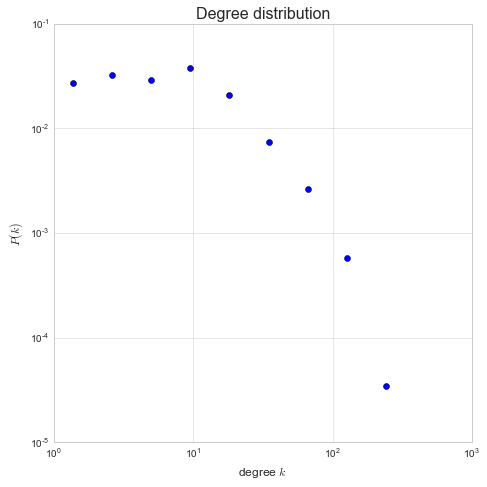

In [402]:
log_binning_plot(values=list(degrees.values()), title="Degree distribution")

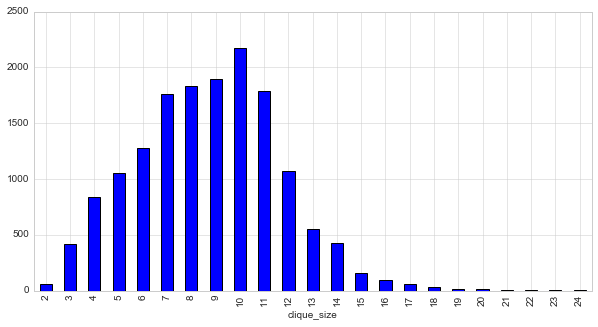

In [403]:
clique_size = pd.DataFrame([{"clique_size": len(x)} for x in nx.find_cliques(network)])
clique_size.groupby("clique_size")["clique_size"].count().plot(kind="bar");